Semblance, Coherence, and other Discontinuity Attributes
==============================

Introduction
-------------

First off, this tutorial is a companion to the short
[article/tutorial](writeup.md) published in The Leading Edge.  If you haven't
yet, have a look at the more detailed introduction there.

Modern 3D seismic interpretation often uses attributes that compare the local
similarity/variance of traces within a seismic volume.  If you're more familiar
with image processing than seismic interpretation, think of them as a class of
3D edge filters adapted for the periodic nature of seismic data (i.e. "wiggles"
instead of more "smooth" data).  These attributes are referred to as
"semblance", "coherence", "similarity", "discontinuity", and many similar
terms, including a number of "trade names" applied to specific implementations
in proprietary software packages.  Here, we'll use the term "discontinuity" to
refer to the general class of attribute, and the others to refer to specific
algorithms.

In practice, you'd typically calculate a discontinuity attribute within a
seismic interpretation package.  In many cases, the algorithms that a
particular software package uses are either considered trade secrets or are not
documented in detail. This leads to discontinuity calculations being treated as
a "black box". Most interpreters use them, but aren't familiar with how they're
calculated. Of course, knowing algorithmic details is not at all necessary to
use discontinuity for interpretation, but it is useful when comparing different
discontinuity attributes or when implementing new methods.

In this tutorial I'll demonstrate algorithms for a few common discontinuity
attributes. I'm going to show simple implementations of a few algorithms with
no regard for practical considerations such as memory use, speed, etc.  The
goal is to show how these types of attributes can be implemented with high-level
"building-blocks". I'm not going to spend much time discussing how, when, or
why one should use one over another.  Which particular algorithm answers a
particular question best is usually specific to the dataset and question at
hand.  Instead, I'll focus on general tradeoffs, such as theoretical
sensitivity to amplitude, noise, etc.  In practice, it's usually best to
compare multiple attributes.  Therefore, the goal of this tutorial is to give you the knowledge to implmenent some of these algorithms and to understand why different discontinuity algorithms give slightly different results.


Our Dataset
-------------

The data we'll be working with is a small subset of the Penobscot 3D seismic dataset [from offshore Nova Scotia](https://opendtect.org/osr/uploads/Main/Penobscot-3D_Loc.jpg), owned by the Nova
Scotia Department of Energy and distributed by dGB Earth Sciences under an
CC-BY-SA license. (Full dataset available at: https://opendtect.org/osr/pmwiki.php/Main/PENOBSCOT3DSABLEISLAND)  

The exact inline/crossline/time ranges of this subset are given in `data/penobscot_subset.hdr`, which is a simple ascii file describing the "raw" data stored in `data/penobscot_subset.bin`.

Stratigraphic Context
----------------------

For context, we're going to be looking at a small region (about 3km by 5km) of the [late Cretaceous to Paleogene section](http://www.callforbids.cnsopb.ns.ca/2013/01/sites/default/files/node/Figure%202.1.jpg) on the Nova Scotian shelf.  The base of our dataset is near the top of the delatic Dawson Canyon formation. The bright, continuous reflectors are within the late Cretaceous Wayndot Chalk.  At the top of these is a major sequence boundary, which incises into the Wayndot Chalk.  The chaotic section at the top of our subset is a distal deltaic section within the Maastrichtian-Paleogene portion of the Banquereau formation, which in this exact area, happens to include a number of mass transport complexes.


Setup
-------

First off, we'll be working in Python.  However, most of these examples focus on using linear algebra and image processing libraries and the concepts should be easily transferrable to other high-level scientific programming languages such as Matlab/Octave or Julia. 

The code in this tutorial depends on Python (2.7 or 3.x) and recent-ish versions of numpy, scipy, and matplotlib.  For 3D visualization, there's an optional dependence on mayavi.

In [1]:
# We'll use non-interactive matplotlib figures embedded in the notebook, for the moment
# Comment this line out or change it to another backend if you'd prefer interactive figures.
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage
import scipy.signal

# Local files included with the notebook
# Note that the "data" folder also has an __init__.py file.
# Therefore the "data" folder is treated as a module with functions
# defined in __init__, like "data.load_seismic" and "data.load_horizon"
import data

Let's define a simple plotting fuction to view a crossline and time slice through a 3D numpy array (we'll use this extensively later):

In [2]:
def plot(data, title=''):
    # We'll take slices half-way through the volume (// is integer division)
    j0 = data.shape[1] // 2
    k0 = data.shape[2] // 2
    
    # Setup subplots where one is 3x the height of the other
    # Our data has a fairly narrow time range, so we'll make a cross section 
    # that's 1/3 the height of the time slice
    gs = plt.GridSpec(4, 1)
    fig = plt.figure(figsize=plt.figaspect(1.1))
    ax1 = fig.add_subplot(gs[:-1], anchor='S')
    ax2 = fig.add_subplot(gs[-1], anchor='N')
    
    # Plot the sections
    ax1.imshow(data[:,:,k0].T, cmap='gray')
    ax2.imshow(data[:,j0,:].T, cmap='gray')
    
    # Mark the cross section locations...
    for ax, loc in zip([ax1, ax2], [j0, k0]):
        ax.axhline(loc, color='red')
        ax.set(xticks=[], yticks=[])
    
    ax1.set(title=title)
    plt.show()

Now let's take a look at our input dataset. Once again, this is a small subset of the Penobscot 3D seismic dataset. We'll load it into memory as a 3D numpy array and display a timeslice and inline section using the `plot` function above:

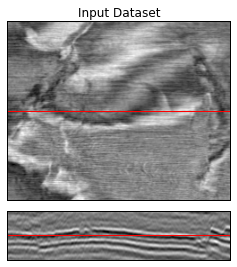

In [3]:
seismic = data.load_seismic()
plot(seismic, 'Input Dataset')

On the right side of the figure, there's a normal fault that tips out towards the top of the time slice.  There are additional features visible in both the time slice and cross section, however, they're difficult to interpret without more detailed investigation.

Speaking of more detailed investigation, you can also explore this dataset in a 3D viewer if you have Mayavi installed. (Click and drag on the secions to move them through the volume.)

In [4]:
from mayavi import mlab

def explore3d(data_cube):
    source = mlab.pipeline.scalar_field(data_cube)
    source.spacing = [1, 1, -1]

    nx, ny, nz = data_cube.shape
    mlab.pipeline.image_plane_widget(source, plane_orientation='x_axes', 
                                     slice_index=nx//2, colormap='gray')
    mlab.pipeline.image_plane_widget(source, plane_orientation='y_axes', 
                                     slice_index=ny//2, colormap='gray')
    mlab.pipeline.image_plane_widget(source, plane_orientation='z_axes', 
                                     slice_index=nz//2, colormap='gray')
    mlab.show()

explore3d(seismic)

One quick comment on execuction speed: I'm deliberately using rather inefficient techniques in most of these examples to keep the code as concise and understandable as possible. Because of that, many of the examples below will take several minutes to run.  If you don't like waiting, consider using a small subset of the data, similar to the subset shown below. (Note: skip the dip-correction example, if you do, as it assumes you're using the full dataset.)

In [5]:
#seismic = data.load_seismic()[10:40, :20, 10:-10]

Now we're ready to explore some various discontinuity attributes. We'll review things in roughly historical order, starting with the earliest approach: Bahorich and Farmer (1995).

Early Algorithms - Cross-correlation
----------------

The earliest discontinuity algorithm was developed by Bahorich and Farmer
(1995) and used the maximum cross correlation value of three traces.  Bahorich
and Farmer coined the term "coherence" for the attribute, based on its
conceptual similarity to pre-stack methods for estimating stacking velocities.
While this exact approach is computationally expensive and not widely used
today, it provides a good starting point to understand later algorithms.

The key here is that the entirety of each trace is correlated with a
"moving-window" subset of two neighboring traces. This has some advantages, such as automatic dip correction, and disadvantages, such as being computationally expensive and sensitive to noise. 

The python function shown below gives a basic example of the algorithm:

In [6]:
def bahorich_coherence(data, zwin):
    ni, nj, nk = data.shape
    out = np.zeros_like(data)
    
    # Pad the input to make indexing simpler. We're not concerned about memory usage.
    # We'll handle the boundaries by "reflecting" the data at the edge.
    padded = np.pad(data, ((0, 1), (0, 1), (zwin//2, zwin//2)), mode='reflect')

    for i, j, k in np.ndindex(ni, nj, nk):
        # Extract the "full" center trace
        center_trace = data[i,j,:]
        
        # Use a "moving window" portion of the adjacent traces
        x_trace = padded[i+1, j, k:k+zwin]
        y_trace = padded[i, j+1, k:k+zwin]

        # Cross correlate. `xcor` & `ycor` will be 1d arrays of length
        # `center_trace.size - x_trace.size + 1`
        xcor = np.correlate(center_trace, x_trace)
        ycor = np.correlate(center_trace, y_trace)
        
        # The result is the maximum normalized cross correlation value
        center_std = center_trace.std()
        px = xcor.max() / (xcor.size * center_std * x_trace.std())
        py = ycor.max() / (ycor.size * center_std * y_trace.std())
        out[i,j,k] = np.sqrt(px * py)

    return out

Now, let's apply this to our test dataset.  Note that we'll need to use a relatively long ``zwin`` window, and that this will take quite some time (5-15 minutes) to compute:

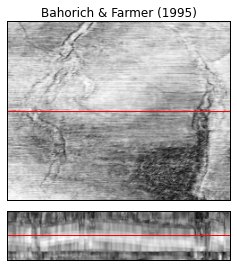

In [7]:
bahorich = bahorich_coherence(seismic, 21)
plot(bahorich, 'Bahorich & Farmer (1995)')

Compared to the "raw" seismic data, this time slice is much easier to interpret. Notice the sinuous features on the left.  While there is likely some minor faulting in addition to the large fault on the right, these sinuous features are easily interpretable as channels in this view, while they were unclear in the timeslice of the "raw" data.

Similar to before, we can view it in 3D if Mayavi is available:

In [8]:
explore3d(bahorich)

If you have time, try varying the ``zwin`` value from 21 to something shorter and longer.  Note that with short windows, the result quickly becomes unclear.  This is because the cross-correlation implictly centers the portion of the trace we're using on its mean, instead of the "true" zero.  For longer traces, the mean is usually zero, but short regions of a trace often hae a non-zero mean.  Due to this, Bahorich and Farmer's algorithm requires large windows and is expensive to compute. 

Generalization to an Arbitrary Number of Traces
-----------------------------------------------
Bahorich and Farmer's (1995) approach was very successful, but it is
sensitive to noise because only three traces are used. Marfurt, et al (1998)
generalized Bahorich and Farmer's cross-correlation approach to an arbitrary
number of input traces, referred to by the authors as "semblance-based
coherence". Marfurt et al's approach also exploits our knowledge that the data
is zero-centered, and avoids centering on the mean of the trace, rather than
the "true" mean of 0. As an example (Note: we'll reuse the ``moving_window``
function in future examples):

In [9]:
def moving_window(data, window, func):
    # `generic_filter` will give the function 1D input. We'll reshape it for convinence
    wrapped = lambda region: func(region.reshape(window))
    
    # Instead of an explicit for loop, we'll use a scipy function to do the same thing
    # The boundaries will be handled by "reflecting" the data, by default
    return scipy.ndimage.generic_filter(data, wrapped, window)

def marfurt_semblance(region):
    # We'll need an ntraces by nsamples array
    region = region.reshape(-1, region.shape[-1])
    ntraces, nsamples = region.shape

    square_of_sums = np.sum(region, axis=0)**2
    sum_of_squares = np.sum(region**2, axis=0)
    return square_of_sums.sum() / sum_of_squares.sum() / ntraces

Now we can apply this to our data (note that it will take a minute or two to compute):

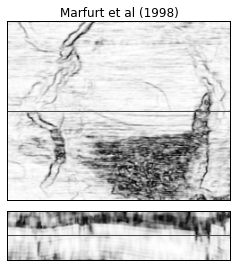

In [10]:
marfurt = moving_window(seismic, (3, 3, 9), marfurt_semblance)
plot(marfurt, 'Marfurt et al (1998)')

Note that both the channels on the left and the fault on the right have become much more clear.  Also, we can now see a discontinuous region (a mass transport complex) in the lower right portion of the timeslice.  We're even starting to get hints of other channels near the upper-left portion of the figure.  

Once again, we can visualize this in 3D, if desired:

In [11]:
explore3d(marfurt)

From an algorithmic perspective, this is similar to Bahorich and Farmer's (1995) approach if the
cross-correlation is only measured at a lag of zero, instead of the maximum
cross correlation. However, Marfurt et al's (1998) method does not require a long
vertical window to produce clear results, leading to faster computational times
and better resolution in the time-direction.  Furthermore, because more
adjacent traces are used, this method is less sensitive to noise, resulting in
a more interpretable result.

Conceptually, Marfurt, et al's (1998) algorithm treats each seismic trace
within the moving window as a separate dimension and measures how close the
resulting point cloud is to a hyper-plane with a slope of 1 in all directions
and intercept of 0.  

It's easiest to visualize for the case of two traces.  For two traces, semblance-based coherence
computes how close the points fall to a line with a slope of 1 and intercept of 0. In the figures below, we'll visualize this by crossplotting two traces. The discretely-sampled amplitude values (blue circles) from each trace will crossplotted on the right-hand portion of the figure.  We'll then measure how close they fall to our line.

Let's start with the case of two identical traces:

<img src="images/semblance_Identical_Traces.png">

When both traces are identical, the values fall perfectly on our line, so the semblance-based coherence is exactly 1.  This is the maximum possible value.

However, if we shift one of the traces down slightly, the samples will have a non-linear pattern:

<img src="images/semblance_Shifted_Traces.png">

Even though the line with a slope of 1 is a good fit to the scatter of points, the points don't fall directly on the line, so the semblance-based coherence is less than 1.

Finally, let's consider what happens when we have two traces with an identical shape, but different amplitudes:

<img src="images/semblance_Different_Amplitude.png">

The samples fall on a perfect line, but the slope of the line is not 1.  Thefore, the semblance-based coherence is below 1.  This is a key theoretical difference between Marfurt, et al's (1998) approach and some other methods.

It is also possible to express this algorithm in terms of a covariance matrix,
where each trace is treated as a separate dimension.  This is mathematically
identical to the example given above, but as we'll see shortly, computing the
covariance matrix allows for other approaches:

In [12]:
def marfurt_semblance2(region):
    region = region.reshape(-1, region.shape[-1])
    ntraces, nsamples = region.shape

    cov = region.dot(region.T)
    return cov.sum() / cov.diagonal().sum() / ntraces

This yields a completely identical result as the implementation shown before. 

Removing Amplitude Sensitivity
------------------------------

One caveat to both Marfurt, et al's (1998) and Bahorich and Farmer's (1995)
method is that they're sensitive to lateral differences in amplitude as well as
differences in phase.  While this is desirable for detecting stratigraphic
features, differences due to lateral changes in amplitude can obscure subtle
structural features.  Gersztenkorn and Marfurt (1999) proposed an
implementation that is sensitive only to lateral changes in phase of the input
waveforms, and not to changes in amplitude: "eigenstructure-based coherence".

Eigenstructure-based coherence (Gersztenkorn and Marfurt, 1999) computes the
covariance matrix of the input region, similar to the previous example.
However, it uses the ratio of the largest eigenvalue of the covariance matrix
to the sum of the eigenvalues:

In [13]:
def gersztenkorn_eigenstructure(region):
    region = region.reshape(-1, region.shape[-1])

    cov = region.dot(region.T)
    vals = np.linalg.eigvalsh(cov)
    return vals.max() / vals.sum()

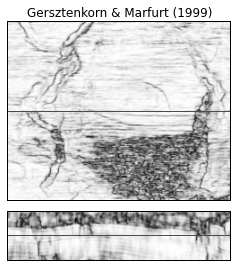

In [14]:
gersztenkorn = moving_window(seismic, (3, 3, 9), gersztenkorn_eigenstructure)
plot(gersztenkorn, 'Gersztenkorn & Marfurt (1999)')

Conceptually, this is similar to treating each seismic trace within the moving
window as a separate dimension and calculating how well the resulting point
cloud is fit by a plane.  To contrast with Marfurt, et al's (1998)
method, for the case of two traces, this measures the scatter about the
best-fit line instead of a line with a slope of 1, as shown below:

Once again, let's start with the case of two identical traces:

<img src="images/eigenstructure_Identical_Traces.png">

When both traces are identical, the values fall perfectly on our line, so the eigenstructure-based coherence is exactly 1, identical to the semblance-based coherence.

When we shift the traces down slightly, we'll change the slop:

<img src="images/eigenstructure_Shifted_Traces.png">

However, even though the slope of best-fit line has changed, the overall scatter around this line is almost identical to a line with a slope of one, so eigenstructure-based and semblance-based coherence estimations give a very similar value.

Finally, let's consider what happens when we have two traces with an identical shape, but different amplitudes:

<img src="images/eigenstructure_Different_Amplitude.png">

The samples fall on a perfect line, but the slope of the line is not 1.  However, unlike semblance-based coherence, eigenstructure-based coherence measures how close the scatter of samples is to the best-fit line. Therefore, Gersztenkorn & Marfurt's (1999) method gives a perfect coherence of 1 in this case.  In other words, eigenstructure-based coherence is only sensitive to phase changes, in theory.  In practice, stratigraphic and structural features are usually expressed through both amplitude and phase changes, so separating the two out is not always advantageous.

Let's look at this side-by-side with Marfurt, et al's (1998) algorithm:

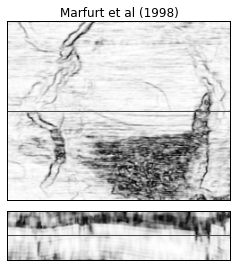

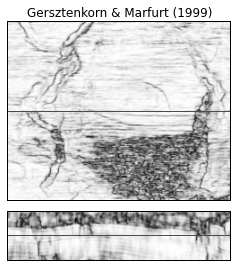

In [15]:
plot(marfurt, 'Marfurt et al (1998)')
plot(gersztenkorn, 'Gersztenkorn & Marfurt (1999)')

Note that Marfurt et al's (1998) method shows more "bold" edges of the channels on the left side of the timeslice.  Because these channels are partly defined by amplitude changes, Gersztenkorn & Marfurt's (1999) approach actually dims the channel edges slightly.  However, it sharpens and more clearly shows fault locations and the internal structure of the mass transport complex at the bottom of the timeslice. This is a good example of the subtle trade-offs between different discontinuity algorithms.

Dip-correction
----------------

A drawback to Marfurt, et al's (1998) and Gersztenkorn and Marfurt's (1999)
approaches is that dipping reflectors will have a uniformly higher
discontinuity (lower coherence/similarity) than non-dipping reflectors. In
other words, these attributes don't distinguish between regional structural dip and
localized discontinuities due to faulting, etc. Therefore, Marfurt
(2006) proposed calculating and correcting for structural dip when performing
discontinuity calculations.   This correction can be applied to any of the
different algorithms discussed so far.  While there are a number of different
methods that can be used to both calculate and correct for structural dip (see
Ch. 2 of Chopra and Marfurt (2007) for a review), dip calculations are beyond
the scope of this tutorial.  Therefore, we'll approximate a dip correction by
flattening on a pre-picked horizon in the interval of interest before applying
a discontinuity calculation.  

In [16]:
def flatten(data, surface, window):
    # Smooth the surface slightly. The surface consists of "raw" integer
    # indices into the seismic cube. If we don't do this, we'll wind up with
    # banding due to the integer nature of the surface.
    surface = scipy.ndimage.gaussian_filter(surface.astype(float), 1)

    ni, nj, nk = data.shape
    ik = np.arange(nk)
    out_ik = np.arange(window) - window // 2

    out = np.zeros((ni, nj, window))
    for i, j in np.ndindex(ni, nj):
        trace = data[i,j,:]
        k = surface[i, j]
        shifted = np.interp(out_ik + k, ik, trace)

        out[i,j,:] = shifted

    return out

def unflatten(data, surface, orig_shape):
    out = np.zeros(orig_shape)
    surface = np.clip(surface, 0, orig_shape[-1] - 1)

    win = data.shape[-1] // 2
    for i, j in np.ndindex(orig_shape[0], orig_shape[1]):
        k = int(surface[i,j])

        outmin, outmax = max(0, k - win), min(orig_shape[-1], k + win + 1)
        inmin, inmax = outmin - (k - win), k + win + 1 - outmax
        inmax = data.shape[-1] - abs(inmax)

        out[i, j, outmin:outmax] = data[i, j, inmin:inmax]

    return out

def dip_corrected(seismic, window, func):
    surface = data.load_horizon()
    flat = flatten(seismic, surface, seismic.shape[-1])
    sembl = moving_window(flat, window, func)
    return unflatten(sembl, surface, seismic.shape)

Now we can apply it using Gersztenkorn & Marfurt's (1999) algorithm:

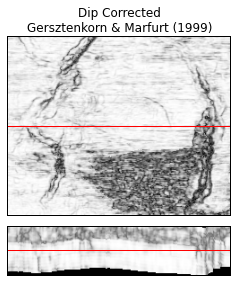

In [17]:
dip_corrected_gersztenkorn = dip_corrected(seismic, (3,3,9), gersztenkorn_eigenstructure)
plot(dip_corrected_gersztenkorn, 'Dip Corrected\nGersztenkorn & Marfurt (1999)')

Or apply it using Marfurt, et al's (1998) algorithm:

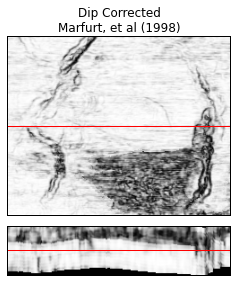

In [18]:
dip_corrected_marfurt = dip_corrected(seismic, (3,3,9), marfurt_semblance)
plot(dip_corrected_marfurt, 'Dip Corrected\nMarfurt, et al (1998)')

The effects of dip correction are less
apparent in our examples due to the relatively low structural dips in the area.
However, dip correction significantly enhances resolution of subtle features in
more structurally complex areas (Marfurt, 2006; Chopra and Marfurt, 2007).

Using the Analytic Trace
------------------------

In addition to dip correction, many authors recommend including the analytic trace in the discontinuity calculation (e.g.
Marfurt, et al, 1999, 2006; Chopra and Marfurt, 2007).  In principle, this
makes the discontinuity estimation less sensitive to zero-crossings in the
original dataset. 

Here's an example of applying this to Gersztenkorn & Marfurt's (1999) algorithm.  We're basically appending the imaginary portion of the analytic trace to the end of the "regular" trace to make each trace twice as long. 

We're also going to be rather inefficent here, and compute the Hilbert transform repeatedly inside the moving window to work around `scipy.ndimage.generic_filter` not supporting complex types. Because of that, this example will take awhile (5-10 minutes) to run:

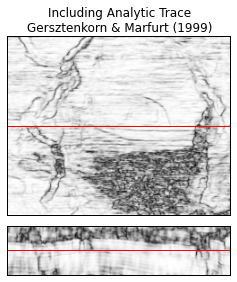

In [19]:
def complex_eigenstructure(region):
    region = region.reshape(-1, region.shape[-1])

    region = scipy.signal.hilbert(region, axis=-1)
    region = np.hstack([region.real, region.imag])

    cov = region.dot(region.T)
    vals = np.linalg.eigvals(cov)
    return np.abs(vals.max() / vals.sum())

complex_gersztenkorn = moving_window(seismic, (3,3,9), complex_eigenstructure)
plot(complex_gersztenkorn, 'Including Analytic Trace\nGersztenkorn & Marfurt (1999)')

In practice, including the analytic trace information often has a very minor effect, unless an unusually small window is chosen.  For example, let's replot the "regular" version of Gersztenkorn & Marfurt's (1999) algorithm applied to this dataset. The differences between these two are almost unnoticable:

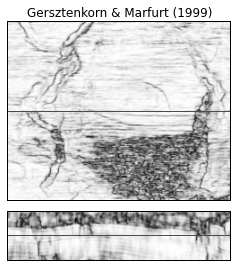

In [20]:
plot(gersztenkorn, 'Gersztenkorn & Marfurt (1999)')

However, if we use a very short time window, we'll start to see significant differences:

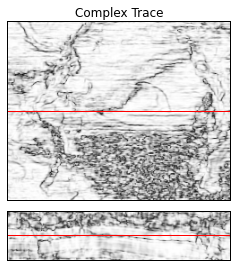

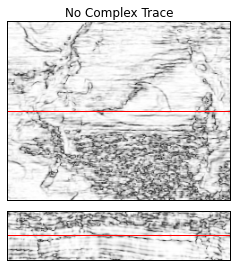

In [21]:
window = (3,3,3)
short_complex = moving_window(seismic, window, complex_eigenstructure)
short_normal = moving_window(seismic, window, gersztenkorn_eigenstructure)

plot(short_complex, 'Complex Trace')
plot(short_normal, 'No Complex Trace')

Notice the "banding" in the bottom cross section of the "No Complex Trace" plot.  Let's plot only the cross sections and make them a bit bigger to show the differences clearly:

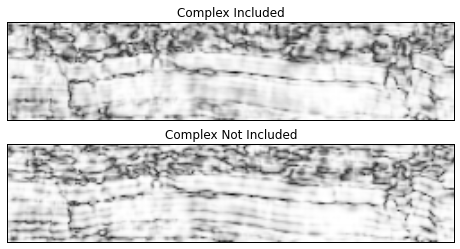

In [22]:
j0 = short_complex.shape[1] // 2

fig, axes = plt.subplots(nrows=2, figsize=plt.figaspect(0.5))
axes[0].imshow(short_complex[:,j0,:].T, cmap='gray')
axes[1].imshow(short_normal[:,j0,:].T, cmap='gray')

axes[0].set(xticks=[], yticks=[], title='Complex Included')
axes[1].set(xticks=[], yticks=[], title='Complex Not Included')
plt.show()

You can see much more pronounced banding parallel to stratigraphy in the bottom image. This is because most covariance-based discontinuity algorithms are sensitive to zero-crossings in the input data.  The imaginary portion of the analytic trace is basically a 90-degree phase shifted version of the original data.  Therefore, it's at a maximum or minimum whenever the real portion crosses zero.  By including the analytic trace, we essentially cancel out the effects of the zero crossings on the discontinuity calculation.  

However, if you're already using a relative long time window, zero-crossings are usually not an issue.  Therefore, it's often better to use a slightly longer window and not include the analytic trace information.

Gradient Structure Tensor
--------------------------

So far, we've mostly focused on algorithms authored by a single group of researchers.  However, there are a number of different discontinuity algorithms that take a very different approach.  A good example of this is the various Gradient Structure Tensor (GST) attributes developed by Randen, et al (2000).  The GST attributes analyze the variability in the local gradient within a moving window.  We'll focus on GST coherence here, but multiple attributes can be derived from the gradient structure tensor, resulting in local dip estimates, texture attributes, and different discontinuity attributes (Randen, et al, 2000).  

Conceptually, the gradient structure tensor measures the three-dimensional change in the local gradient of the seismic data.  Therefore, a dip estimate is inherent in the calculation, and no separate dip-correction is required.  However, similar to semblance-based coherence (Marfurt, et al, 1998) it is sensitive to amplitude changes as well as phase changes.  GST coherence differs from the other discontinuity attributes in what it measures.  The other discontinuity attributes we've discussed so far measure similarity of adjacent waveforms.  GST coherence measures how constant the local gradient/slope of the seismic data is.  In that sense, it's more similar to the various volumetric curvature attributes than to other discontinuity attributes.  

Let's take a look at a simple implementation built on top of `scipy.ndimage`.  Randen, et al (2000) use a Gaussian gradient operator to estimate the local gradient, and we'll follow suit here:

In [23]:
def gradients(seismic, sigma):
    """Builds a 4-d array of the gaussian gradient of *seismic*."""
    grads = []
    for axis in range(3):
        # Gaussian filter with order=1 is a gaussian gradient operator
        grad = scipy.ndimage.gaussian_filter1d(seismic, sigma, axis=axis, order=1)
        grads.append(grad[..., np.newaxis])
    return np.concatenate(grads, axis=3)

def moving_window4d(grad, window, func):
    """Applies the given function *func* over a moving *window*, reducing 
    the input *grad* array from 4D to 3D."""
    # Pad in the spatial dimensions, but leave the gradient dimension unpadded.
    half_window = [(x // 2, x // 2) for x in window] + [(0, 0)]
    padded = np.pad(grad, half_window, mode='reflect')
    
    out = np.empty(grad.shape[:3], dtype=float)
    for i, j, k in np.ndindex(out.shape):
        region = padded[i:i+window[0], j:j+window[1], k:k+window[2], :]
        out[i,j,k] = func(region)
    return out

def gst_coherence_calc(region):
    """Calculate gradient structure tensor coherence on a local region.
    Intended to be applied with *moving_window4d*."""
    region = region.reshape(-1, 3)
    gst = region.T.dot(region) # This is the 3x3 gradient structure tensor
    
    # Reverse sort of eigenvalues of the GST (largest first)
    eigs = np.sort(np.linalg.eigvalsh(gst))[::-1]
    
    return (eigs[0] - eigs[1]) / (eigs[0] + eigs[1])
        
def gst_coherence(seismic, window, sigma=1):
    """Randen, et al's (2000) Gradient Structure Tensor based coherence."""
    # 4-d gradient array (ni x nj x nk x 3)
    grad = gradients(seismic, sigma)
    return moving_window4d(grad, window, gst_coherence_calc)

Now let's apply this to our seismic cube. Note that this will take a bit to run (~5 minutes):

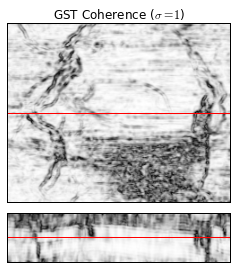

In [24]:
gst_coh = gst_coherence(seismic, (3, 3, 9), sigma=1)
plot(gst_coh, r'GST Coherence ($\sigma=1$)')

One additional "knob" that this algorithm has is the width of the gaussian gradient operator that's applied to calculate the gradient structure tensor.  In the example above, that's the `sigma` parameter, which in this specific case is in "voxel" units (i.e. raw indices). Varying this parameter changes the distance that the gradient is calculated over, and therefore the wavelength of features that the attribute is sensitive to.  

In the case of the other discontinuity attributes we've discussed, the spatial resolution and size of the geologic features the attribute is sensitive to are tightly coupled through the size of the `window` over which the attribute is calculated.  In this case, we can in theory calculate an attribute that's sensitive to larger features without reducting the lateral/vertical resolution.

For example, if we increase `sigma` by a factor of two from the figure above, we'll better image many of the major geologic features that we were seeing in the previous discontinuity attributes:

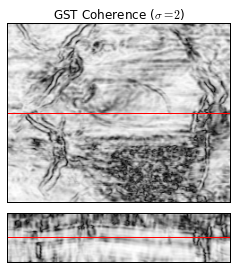

In [25]:
gst_coh = gst_coherence(seismic, (3, 3, 9), sigma=2)
plot(gst_coh, r'GST Coherence ($\sigma=2$)')

If we reduce `sigma` to half of the original value, the attribute will be sensitive only to short-wavelength changes, and we'll miss many of the larger channels and faults in our data:

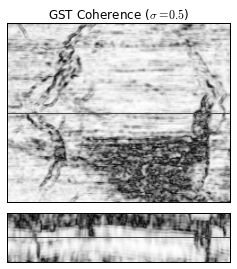

In [26]:
gst_coh = gst_coherence(seismic, (3, 3, 9), sigma=0.5)
plot(gst_coh, r'GST Coherence ($\sigma=0.5$)')

However, because the GST operates on the "raw" seismic data, if we make `sigma` too large, we'll start to have issues with phase-skipping. In other words, we'll see broad regions of low or high coherence due to a peak being compared to an adjacent trough or a peak a stratigraphically different reflector. This manifests itself as broad regions of high/low discontinuity that don't directly correspond to geologic features.

For example, if we calculate the attribute with `sigma=3`:

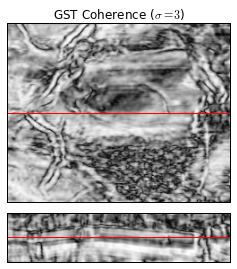

In [27]:
gst_coh = gst_coherence(seismic, (3, 3, 9), sigma=3)
plot(gst_coh, r'GST Coherence ($\sigma=3$)')

Effect of Window Size and Shape
------------------------------------

All discontinuity algorithms we've discussed are applied over a moving window.  The size of this window controls both the spatial resolution of the attribute and the size of features that the attribute is sensitive to.  Therefore, the size and shape of the window over which an attribute is applied is a key component of any of these discontinuity measurements.  

The scipy ecosystem gives us the tools to easily apply non-rectangular filters. `scipy.ndimage.generic_filter` takes a `footprint` argument which determines the shape of the region that the given function is applied over.  For example, if we wanted to apply Marfurt, et al (1998)'s discontinuity algorithm over a broadly elliptical window with the long-axis parallel to the crossline direction, we could do something similar to:

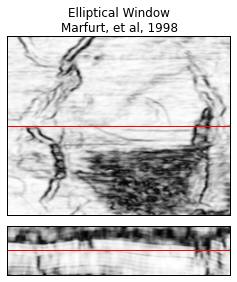

In [28]:
def arbitrary_moving_window(seismic, window, func, footprint):
    footprint = np.asarray(footprint)
    ntraces = footprint.sum()
    wrapped = lambda region: func(region.reshape(ntraces, -1))
    
    if footprint.ndim == 2:
        footprint = np.tile(footprint[..., np.newaxis], (1, 1, window[0]))
    return scipy.ndimage.generic_filter(seismic, wrapped, window, footprint=footprint)

footprint = [[0, 0, 1, 0, 0],
             [0, 1, 1, 1, 0],
             [0, 1, 1, 1, 0],
             [1, 1, 1, 1, 1],
             [0, 1, 1, 1, 0],
             [0, 1, 1, 1, 0],
             [0, 0, 1, 0, 0]]
result = arbitrary_moving_window(seismic, (7, 7, 9), marfurt_semblance, footprint)
plot(result, 'Elliptical Window\nMarfurt, et al, 1998')

However, a more basic consideration than kernel shape in most cases is the overall size of the kernel/moving-window over which the attribute is calculated.  This controls both the spatial resolution of the calculation and the size of the geologic feature which it is sensitive to.

To help us build up a bit of intuition about how the size of the moving window affects the discontinuity attribute, let's set up an interactive widget to vary window size and see the result.  To speed up the calculation, we'll apply it only to a timeslice of our data.  Because we're working in a Jupyter notebook, we'll use IPython widgets instead of using an interactive matplotlib slider.

However, as you've probably noticed, most of these calculations are quite slow. It is possible to speed things up dramatically without leaving Python, but it makes the implmenation considerably less understandable.  Therefore, to make the interactive slider responsive, we'll only apply the calculation to a small portion of our data.  Let's plot that portion to get a sense of what we're looking at:

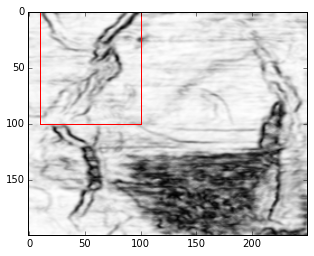

In [29]:
sub = np.s_[10:100, :100, :]
tslice = result[..., seismic.shape[-1] // 2]

fig, ax = plt.subplots()
ax.imshow(tslice.T, cmap='gray')
ax.bar(sub[0].start, sub[1].stop, sub[0].stop - sub[0].start, 0,
       facecolor='none', edgecolor='red')
ax.axis('image')
plt.show()

subset = data.load_seismic()[sub]

In [30]:
def apply_timeslice(seismic, window, func):
    k0 = int(seismic.shape[-1]) // 2
    iwin, jwin, kwin = window
    
    padded = np.pad(subset, [(win//2, win//2) for win in window], mode='reflect')
    
    out = np.zeros(seismic.shape[:2], dtype=float)
    for i, j in np.ndindex(out.shape):
        region = padded[i:i+iwin, j:j+jwin, k0:k0+kwin]
        out[i,j] = func(region)
    return out

def plot_timeslice(attr):
    fig, ax = plt.subplots()
    ax.imshow(attr.T, cmap='gray')
    plt.show()

Okay, so now we're going to apply Marfurt, et al's (1998) discontinutiy algorithm to a small region (red box above) of our data.  Let's set up an interactive slider to vary the xy window size:

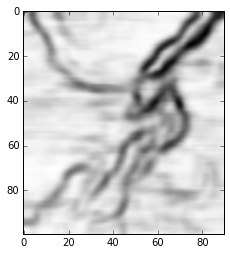

In [31]:
import ipywidgets

def change_window(xwin):
    attr = apply_timeslice(subset, (xwin, xwin, 9), marfurt_semblance)
    plot_timeslice(attr)

ipywidgets.interact(change_window, xwin=(2, 11, 1))

Now let's set up a similar slider to vary the z-window size:

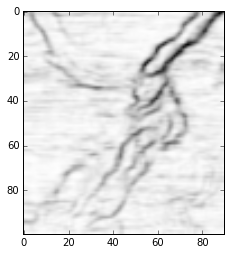

In [32]:
def change_zwindow(zwin):
    attr = apply_timeslice(subset, (3, 3, zwin), marfurt_semblance)
    plot_timeslice(attr)

ipywidgets.interact(change_zwindow, zwin=(2, 21, 1))

Summary of Trade-Offs
---------------------

The four methods we've discussed so far all have advantages and disadvantages.  Some of these trade-offs are listed below:

| Name      | Reference    | Speed    | Amplitude Sensitive  | Dip-correction Needed |
|-----------|--------------|:--------:|:--------------------:|:---------------------:|
| Coherence | Bahorich & Farmer (1995) | 4 (slowest)| No | No |
| Semblance | Marfurt, et al (1998) | 1 (fastest) | Yes | Yes |
| Eigenstructure | Gersztenkorn and Marfurt (1999) | 3 | No | Yes |
| Gradient Structure Tensor | Randen, et al (2000) | 2 | Yes | No |

Bahorich and Farmer's (1995) original method is the most computationally intensive, if implemented exactly as described.  Marfurt, et al's (1998) semblance-based attribute is the least computationally expensive.  Also,  implementing semblance-based coherence using a matrix multiplication instead of explicit sums, as shown in `marfurt_semblance2` method above, is often faster than the explict sum method because it can take advantage of optimized linear algebra routines.  Gersztenkorn and Marfurt's (1999) eigenstructure-based coherence and Randen, et al's (2000) GST-based coherence methods both require eigenvalue calculations.  This results in both methods being slower than Marfurt, et al's (1998) semblance-based coherence method.  Randen, et al's (2000) structure tensor calculation also requires the a gaussian gradient estimation instead of operating directly on the seismic data.  However, the eigenvalue calculation for Randen et al's (2000) method is always on a 3x3 tensor.  For eigenstructure-based coherence, the size of the covariance matrix is a function of the number of traces.  For large windows, calculating the eigenvalues of a 25x25 or larger tensor overwhelms the extra time taken for the gradient calculation in Randen et al's (2000) method.  At any rate, GST based and eigenstructure based coherence have relatively similar calculation times in most implementations, but eigenstructure-based coherence is typically slower for large windows.

Depending on your task at hand, amplitude sensitivity may be either a positive or a negative.  Regardless, few geologic features have only an amplitude response with no corresponding change in the shape of the waveform.  Therefore, the phase-only advantage that Bahorich & Farmer's (1995) original coherence and Gersztenkorn and Marfurt's (1999) eigenstructure-based coherence methods have is not always useful in practice.

Semblance-based coherence (Marfurt, et al 1998) and Eigenstructure-based coherence (Gersztenkorn and Marfurt, 1999) are both sensitive to the structural dip, while the other two methods implicitly compensate for it in the calculation.  In practice, most commercial implementations of the dip-sensitive methods include a dip-correction option.  Therefore, this is usually not a major difference between the methods as applied in interpretation packages. However, there are some cases where having a dip-sensitive discontinuity attribute can be advantageous.  For example, in addition to clearly imaging faults, a non-dip corrected discontinuity attribute can show the map-view expression of fold limbs or kink panels as a broad band of uniformly lower coherence.  Co-rendering discontinuity along with a dip or azimuth calculation is a more effective way to visualize faults and kink panels together, but requires additional work.  The same information can sometimes be gleaned from a non-dip corrected semblance-based coherence attribute.



Final Thoughts
---------------

Hopefully this tutorial has helped you "peek behind the curtains" at how discontinuity algorithms are implemented.  However, I've only brushed the surface here. There are many more coherence/discontinuity algorithms than the ones discussed above.  Chapter 2 of Chopra and Marfurt (2006) has an excellent review.  Many of the algorithms described there can be implemented using the "building blocks" shown in this tutorial.  If you're feeling ambitious, give it a try!

References
----------

Bahorich, M., and S. Farmer, 1995, 3-D seismic discontinuity for faults and stratigraphic features: The coherence cube: The Leading Edge, **14**, 1053-1058.
doi:10.1190/1.1437077

Chopra, S., and K. J. Marfurt, 2007, Seismic Attributes for Prospect Identification and Reservoir Characterization: **SEG**
doi:10.1190/1.9781560801900

Gersztenkorn, A., and K. J. Marfurt, 1999, Eigenstructure‐based coherence computations as an aid to 3-D structural and stratigraphic mapping: GEOPHYSICS, **64**, 1468-1479.
doi:10.1190/1.1444651

Marfurt, K., V. Sudhaker, A. Gersztenkorn, K. D. Crawford, and S. E. Nissen, 1999, Coherency calculations in the presence of structural dip: GEOPHYSICS, **64**, 104-111.
doi:10.1190/1.1444508

Marfurt, K. J., 2006, Robust estimates of 3D reflector dip and azimuth: GEOPHYSICS, **71**, no. 4, P29-P40.
doi:10.1190/1.2213049

Nova Scotia Department of Energy, 1992, Penobscot 3D Survey. Dataset accessed 19 October, 2015 at
https://opendtect.org/osr/pmwiki.php/Main/PENOBSCOT3DSABLEISLAND

Randen, T., E. Monsen, C. Singe, A. Abrahamsen, J. Hansen, T. Saeter, and J. Schlaf, 2000, Three-dimensional texture attributes for seismic data analysis, 70th Annual International Meeting, **SEG**, Expanded Abstracts, 668-671.

Taner, M. T., And F. Koehler, 1969, Velocity Spectra—Digital Computer Derivation Applications of Velocity Functions: Geophysics, **34**, 859-881.
doi:10.1190/1.1440058
